# Feature engineering

This notebook contains the preprocessing steps of available datasets:
From outside soure Credit Bureau:
* bureau_balance.csv
* bureau.csv

From Home Credit previous data:
* POS_CASH_balance.csv
* installments_payments.csv
* credit_card_balance.csv
* previous_application.csv

From Home Credit current data:
* application_train.csv

The approach to this preprocessing is as follow:
* clean the data based on EDA (removing nonsense values, changing sign of values, replacing categorical values with number)
* adding new features
* reducing cardinality
* calculating number of previous credits and aggregating on bahavioural data from last 2 years and over 2 years
* selecting features based on features with distribution that don't shift and have the roc_auc preformance of single features in predicting the target is highier than 0.52
* saving preprocessed data

To minimize the usage of RAM each dataframe will be called and deleted accordingly. 

### Importing libraries and helper functions

In [96]:
import numpy as np
import pandas as pd
from typing import List
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from feature_engine.encoding import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from feature_engine.creation import MathFeatures
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import FunctionTransformer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import  RecursiveFeatureElimination
from feature_engine.selection import DropHighPSIFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from feature_engine.encoding import RareLabelEncoder
from sklearn.model_selection import StratifiedKFold
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropHighPSIFeatures
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from feature_engine.discretisation import EqualWidthDiscretiser
from sklearn.linear_model import LogisticRegression
import feature_engine
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import MinMaxScaler
from feature_engine.encoding import RareLabelEncoder, MeanEncoder
from feature_engine.discretisation import DecisionTreeDiscretiser
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import WoEEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.width = None
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:,.2f}'.format

Helper functions:

In [97]:
def reduce_memory_usage(df: DataFrame) -> DataFrame:
    """Reduced memory usage by downcasting datatype of columns.
    Input: DataFrame
    Output: DataFrame"""

    for column in df:
        if df[column].dtype in ["float64", "float32"]:
             df[column]=pd.to_numeric(df[column], downcast="float")
        if df[column].dtype in ["int64", "int32"]:
            df[column]=pd.to_numeric(df[column], downcast="integer")
    return df

def load_data(name: str) -> DataFrame:

    """Loads DataFrame from csv and reduces used memory.
    Parameters: name (the name of csv file without .csv extension)
    Returns: DataFrame"""
    
    print('-'*100)
    print(f'{name}.csv loading')
    df = pd.read_csv(f'{name}.csv')
    memory = df.memory_usage().sum() / 1024**2
    df = reduce_memory_usage(df)
    print(f'memory usage reduced from {memory:.1f}MB to {(df.memory_usage().sum() / 1024**2):.1f}MB')
    print('-'*100)
    return df


def organization_replacer(value: any) -> any:
    """Reduces the number of unique values 
    where there are subcategories with ':' sign"""
    
    if value not in [np.nan, None]:
        x = value.split()[0]
        if x[-1] ==":":
            return x[:-1]
        elif x == "Business":
            return "Business"
    return value

def yes_no_replacer(value: str) -> int:
    """Encodes yes, no columns to 0 and 1"""
    if value is ['Y', 'Yes']:
        return 1
    elif value in ['N', 'No']:
        return 0


def days_replacer(value: float) -> float:
    if value not in [np.nan, None]:
        return round((value / -365), 2)

def pie_plot(df: DataFrame, col_name: str, labels: List) -> None:
    """Plots a pie chart of distribution of chosen column."""
    
    # Data to plot
    plot_data = df[col_name].value_counts() / df.shape[0]
    
    # Pie plot
    plt.title(f"Pie chart of {col_name} variable")
    plt.pie(plot_data, labels=labels, labeldistance=1.15, 
            wedgeprops= { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')

    """Plots bargraph of features with the highiest importance in predicting target.
    Params: num_imp (number of important features as int)"""

    # Getting important features and their performance
    important_features = sorted(selection_pipe.named_steps['sfp'].feature_performance_.items(), key=lambda x: x[1], reverse=True)[:num_imp]

    # Preparing dictionary of important features
    important_features = {key : round(value, 2) for key, value in important_features}

    # Transforming to pd.Series
    important_features = pd.Series(important_features)

    # Plotting 
    fig, ax = plt.subplots()
    bar_container = sns.barplot(x=important_features.values, y=important_features.index, ax=ax)
    plt.bar_label(ax.containers[0], padding=7)
    plt.xticks([])
    plt.title('ROC_AUC of single feature preformance')
    sns.despine(bottom=True)

def remove_special_chars(s):  # working one
    return ''.join(e if e.isalnum() else '_' for e in s)

def plot_important_features(num_imp: int=10) -> None:
    """Plots bargraph of features with the highiest importance in predicting target.
    Params: num_imp (number of important features as int)"""

    # Getting important features and their performance
    important_features = sorted(selection_pipe.named_steps['sfp'].feature_performance_.items(), key=lambda x: x[1], reverse=True)[:num_imp]

    # Preparing dictionary of important features
    important_features = {key : round(value, 2) for key, value in important_features}

    # Transforming to pd.Series
    important_features = pd.Series(important_features)

    # Plotting 
    fig, ax = plt.subplots()
    bar_container = sns.barplot(x=important_features.values, y=important_features.index, ax=ax)
    plt.bar_label(ax.containers[0], padding=7)
    plt.xticks([])
    plt.title('ROC_AUC of single feature preformance')
    sns.despine(bottom=True)

def change_sign(value):
    if value < 0:
        return value*(-1)

def y_n_encode(value):
    if value == 'Y':
        return 1
    elif value == 'N':
        return 0

def dataframe_info_decorator(func):
    """Decorator function to display most important features of the DataFrame"""
    def wrapper(*args, **kwargs):
        df = func(*args, **kwargs)
        print(f"{'-'*50} DataFrame Information {'-'*50}")
        print(f"Features: {df.shape[1]}")
        print(f"Entries: {df.shape[0]}")
        print('-'*123)
        display(df.head(2))
        return df
    return wrapper
from typing import Set

@dataframe_info_decorator
def create_dataframe(df: DataFrame, values: Set, columns: List, col_name: str ='SK_ID_CURR') -> DataFrame:
    """Creates a dataframe with the set of values from chosen column and chosen column names"""
    df = df[columns].loc[df[col_name].isin(values)]
    return df



def mean_knn(x):
    nn_100 = NearestNeighbors(n_neighbors=100)
    df_nn = x[['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3', 'AMT_CREDIT', 'AMT_ANNUITY']]
    df_nn['CREDIT_ANNUITY_RATIO'] = x['AMT_CREDIT'] /(x['AMT_ANNUITY'] + 0.0001)
    nn_100.fit(df_nn)        
    train_100_neighbours = nn_100.kneighbors(df_nn)[1] # getting indices of neighbours 
    new_column_1 = [y_train.iloc[ind].mean() for ind in train_100_neighbours]
    
    nn_50 = NearestNeighbors(n_neighbors=50)
    nn_50.fit(df_nn)
    train_50_neighbours = nn_50.kneighbors(df_nn)[1]
    new_column_2 = [y_train.iloc[ind].mean() for ind in train_50_neighbours]
    return np.column_stack((x, new_column_1, new_column_2))

def devision(x):
    return x[0]/(x[1]+0.001)
    
def sum_dev(x):
    return (x[0]+x[1])*x[2]/2
    
def weighted_mul(x):
    return x[0]*2 + x[1]*3 + x[2]*4

def remove_special_chars(s):  # working one
    return ''.join(e if e.isalnum() else '_' for e in s)


## Splitting data

There are 3 sets of SK_ID_CURR which need to be split in stratified version:
* applications with previous history in credit bureau
* applications with previous history in home credit
* applications without previous history

Based on the ids we can keep testing data intact.

In [77]:
# Loading columns for merging with application_train.csv
id_and_target = pd.read_csv('application_train.csv').loc[:, ['SK_ID_CURR', 'TARGET']]

# Getting all ids
application_ids = set(id_and_target['SK_ID_CURR'].unique())

### Splitting bureau.csv

In [79]:
# Loading data from bureau.csv
bureau = pd.read_csv('bureau.csv').loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']]

# Getting set of unique ids
bureau_ids = set(bureau['SK_ID_CURR'].unique())

# Getting data with SK_ID_CURR and TARGET variable to perform the split
bureau_for_split = id_and_target.loc[id_and_target['SK_ID_CURR'].isin(bureau_ids)]

# Selecting X and y
X = bureau_for_split['SK_ID_CURR']
y = bureau_for_split['TARGET']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, train_size=0.5, random_state=42)

# Getting SK_ID_CURR 
bureau_id_curr_train = set(X_train.unique())
bureau_id_curr_val = set(X_val.unique())
bureau_id_curr_test = set(X_test.unique())

### Splitting previous_application.csv

In [80]:
# Loading data from precious_applications.csv
previous = pd.read_csv('previous_application.csv').loc[:, ['SK_ID_CURR', 'SK_ID_PREV']]

# Getting set of unique ids
previous_ids = set(previous['SK_ID_CURR'].unique())

# Getting data for split
previous_for_split = id_and_target.loc[id_and_target['SK_ID_CURR'].isin(previous_ids)]

# Selecting X and y
X = previous_for_split['SK_ID_CURR']
y = previous_for_split['TARGET']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, train_size=0.5, random_state=42)

# Getting SK_ID_CURR 
previous_id_curr_train = set(X_train.unique())
previous_id_curr_val = set(X_val.unique())
previous_id_curr_test = set(X_test.unique())

### Splitting data with no history

In [83]:
# Getting set of unique id
no_history_ids = application_ids - (previous_ids | bureau_ids)

# No history for split
no_history_for_split = id_and_target.loc[id_and_target['SK_ID_CURR'].isin(no_history_ids)]

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, train_size=0.5, random_state=42)

# Getting SK_ID_CURR 
no_history_id_curr_train = set(X_train.unique())
no_history_id_curr_val = set(X_val.unique())
no_history_id_curr_test = set(X_test.unique())

### SK_ID_CURR of splits in application_train.csv

In [84]:
application_id_train = no_history_id_curr_train | previous_id_curr_train | bureau_id_curr_train
application_id_val = no_history_id_curr_val | previous_id_curr_val | bureau_id_curr_val
application_id_test = no_history_id_curr_test | previous_id_curr_test | bureau_id_curr_test

## Preprocess bureau and bureau_balance

Preprocessing bureau_balance:
* encode the status
* sort in ascending order by id and balance
* calculating weighted status - additional feature
* calculating how many years back the credit was taken
* aggregating features from fresh and old credit history (last 2 years and above)

### Getting data

In [7]:
bureau_balance = load_data('bureau_balance')

----------------------------------------------------------------------------------------------------
bureau_balance.csv loading
memory usage reduced from 624.8MB to 338.5MB
----------------------------------------------------------------------------------------------------


To refresh the knowladge on missing values. This dataframe is complete and the missing values occure in STATUS column marked as X.

In [8]:
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

### Initial preprocessing based on EDA

In [9]:
# Encoding status 
dict_for_status = { 'C': 1, '0': 2, '1': 3, '2': 4, 'X': 5, '3': 6, '4': 7, '5': 8}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

# Sort in ascending order
bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0,0])

# Change sign of month
bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'].apply(lambda x : -x)

# Calculate weighted status
bureau_balance['WEIGHTED_STATUS'] = bureau_balance['STATUS'] / (bureau_balance['MONTHS_BALANCE'] + 1)

# Calculate years
bureau_balance['YEARS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

### Aggregating on SK_ID_BUREAU

In [16]:
# ============================== last 2 years ==============================

# Calculating aggreagations from last 2 years
fresh_bureau_balance = bureau_balance.loc[bureau_balance['YEARS_BALANCE'] <=2]

# Dictionary for aggregations
aggregations_fresh = {
    'MONTHS_BALANCE' : ['mean', 'min'],
    'STATUS': ['mean', 'max', 'first'],
    'WEIGHTED_STATUS': ['mean', 'std'] 
}

# Aggreagtions and columns naming
fresh_bureau_balance = fresh_bureau_balance.groupby(['SK_ID_BUREAU']) \
                       .agg(aggregations_fresh)
fresh_bureau_balance.columns = [f"FRESH_{'_'.join(ele).upper()}" 
                                for ele in fresh_bureau_balance.columns]

# ============================== over 2 years ==============================

# Calculating aggregations from last 2 years
old_balance_history = bureau_balance.loc[bureau_balance['YEARS_BALANCE'] > 2]

# Dictionary for aggreagtions
aggregations_old = {
    'MONTHS_BALANCE' : ['mean', 'max'],
    'STATUS': ['mean', 'max', 'count'],
    'WEIGHTED_STATUS': ['mean', 'std'] 
}

# Aggreagations and column naming
old_bureau_balance = old_balance_history.groupby(['SK_ID_BUREAU']) \
                    .agg(aggregations_old)
old_bureau_balance.columns = [f"OLD_{'_'.join(ele).upper()}" 
                              for ele in old_bureau_balance.columns]

In [27]:
# Merging old and fresh balance 
agg_bureau_balance = old_bureau_balance.merge(fresh_bureau_balance, 
                                              right_index=True, 
                                              left_index=True, 
                                              how='outer')

# Filling in missing values for clients without older history
agg_bureau_balance.fillna(0, inplace=True)

# Displaying outcome
agg_bureau_balance.head(2)

,OLD_MONTHS_BALANCE_MEAN,OLD_MONTHS_BALANCE_MAX,OLD_STATUS_MEAN,OLD_STATUS_MAX,OLD_STATUS_COUNT,OLD_WEIGHTED_STATUS_MEAN,OLD_WEIGHTED_STATUS_STD,FRESH_MONTHS_BALANCE_MEAN,FRESH_MONTHS_BALANCE_MIN,FRESH_STATUS_MEAN,FRESH_STATUS_MAX,FRESH_STATUS_FIRST,FRESH_WEIGHTED_STATUS_MEAN,FRESH_WEIGHTED_STATUS_STD
SK_ID_BUREAU,,,,,,,,,,,,,,
5001709,66.00,96.00,1.72,5.00,61.00,0.02,0.01,17.50,0.00,1.00,1.00,1.00,0.12,0.18
5001710,59.00,82.00,3.66,5.00,47.00,0.06,0.02,17.50,0.00,1.00,1.00,1.00,0.12,0.18


### Saving outcome and deleting unnecessary data

In [33]:
# Saving to csv in a new directory for preprocessed data
agg_bureau_balance.to_csv("preprocessed_data/agg_bureau_balance.csv")

In [34]:
# del bureau_balance

## Preprocessing of bureau.csv:

* getting data and merging with aggregated bureau_balance
* replacing nonsense data based on EDA (replace any value with credits over 50 years with NaN)
* engineering of new features
* aggregating features on SK_ID_CURR and CREDIT_ACTIVE column -> extracting data for Active and Closed credits
* selecting features

### Getting data

In [42]:
# Loading dataframe
bureau = load_data('bureau')

# Merging with oucome from preprocessing of bureau_balance
bureau_merged = bureau.merge(agg_bureau_balance, left_on='SK_ID_BUREAU', right_index=True, how='left')

# Displaying outcome
print('Merged dataset of bureau.csv and aggregations from bureau_balance.csv')
bureau.head(2)

----------------------------------------------------------------------------------------------------
bureau.csv loading
memory usage reduced from 222.6MB to 158.8MB
----------------------------------------------------------------------------------------------------
Merged dataset of bureau.csv and aggregations from bureau_balance.csv


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN


### Initial cleaning based on EDA

In [43]:
# Cleaning data from nonsense values
columns_to_replace = ['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']
bureau_merged[columns_to_replace] = bureau_merged[columns_to_replace].apply(lambda x: np.where(x > -50*365, np.nan, x))

### Adding feature

In [44]:
# Feature engineering
bureau_merged['RATIO_OF_PAID_AMT'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / bureau_merged['AMT_CREDIT_SUM']

### Aggregating on SK_ID_CURR and CREDIT_ACTIVE 

In [45]:
# Drop column that won't be needed 
bureau_merged.drop('SK_ID_BUREAU', axis=1, inplace=True)

# Aggregating on SK_ID_CURR and CREDIT_ACTIVE
agg_bureau = bureau_merged.groupby(['SK_ID_CURR', 'CREDIT_ACTIVE']).agg(['min', 'max', 'mean'])
agg_bureau.columns = ['_'.join(ele).upper() for ele in agg_bureau.columns]
agg_bureau.reset_index(inplace=True)
agg_bureau.head(2)

,SK_ID_CURR,CREDIT_ACTIVE,DAYS_CREDIT_MIN,DAYS_CREDIT_MAX,DAYS_CREDIT_MEAN,CREDIT_DAY_OVERDUE_MIN,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_ENDDATE_FACT_MIN,DAYS_ENDDATE_FACT_MAX,DAYS_ENDDATE_FACT_MEAN,AMT_CREDIT_MAX_OVERDUE_MIN,AMT_CREDIT_MAX_OVERDUE_MAX,AMT_CREDIT_MAX_OVERDUE_MEAN,CNT_CREDIT_PROLONG_MIN,CNT_CREDIT_PROLONG_MAX,CNT_CREDIT_PROLONG_MEAN,AMT_CREDIT_SUM_MIN,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_DEBT_MIN,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_LIMIT_MIN,AMT_CREDIT_SUM_LIMIT_MAX,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_OVERDUE_MIN,AMT_CREDIT_SUM_OVERDUE_MAX,AMT_CREDIT_SUM_OVERDUE_MEAN,DAYS_CREDIT_UPDATE_MIN,DAYS_CREDIT_UPDATE_MAX,DAYS_CREDIT_UPDATE_MEAN,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,OLD_MONTHS_BALANCE_MEAN_MIN,OLD_MONTHS_BALANCE_MEAN_MAX,OLD_MONTHS_BALANCE_MEAN_MEAN,OLD_MONTHS_BALANCE_MAX_MIN,OLD_MONTHS_BALANCE_MAX_MAX,OLD_MONTHS_BALANCE_MAX_MEAN,OLD_STATUS_MEAN_MIN,OLD_STATUS_MEAN_MAX,OLD_STATUS_MEAN_MEAN,OLD_STATUS_MAX_MIN,OLD_STATUS_MAX_MAX,OLD_STATUS_MAX_MEAN,OLD_STATUS_COUNT_MIN,OLD_STATUS_COUNT_MAX,OLD_STATUS_COUNT_MEAN,OLD_WEIGHTED_STATUS_MEAN_MIN,OLD_WEIGHTED_STATUS_MEAN_MAX,OLD_WEIGHTED_STATUS_MEAN_MEAN,OLD_WEIGHTED_STATUS_STD_MIN,OLD_WEIGHTED_STATUS_STD_MAX,OLD_WEIGHTED_STATUS_STD_MEAN,FRESH_MONTHS_BALANCE_MEAN_MIN,FRESH_MONTHS_BALANCE_MEAN_MAX,FRESH_MONTHS_BALANCE_MEAN_MEAN,FRESH_MONTHS_BALANCE_MIN_MIN,FRESH_MONTHS_BALANCE_MIN_MAX,FRESH_MONTHS_BALANCE_MIN_MEAN,FRESH_STATUS_MEAN_MIN,FRESH_STATUS_MEAN_MAX,FRESH_STATUS_MEAN_MEAN,FRESH_STATUS_MAX_MIN,FRESH_STATUS_MAX_MAX,FRESH_STATUS_MAX_MEAN,FRESH_STATUS_FIRST_MIN,FRESH_STATUS_FIRST_MAX,FRESH_STATUS_FIRST_MEAN,FRESH_WEIGHTED_STATUS_MEAN_MIN,FRESH_WEIGHTED_STATUS_MEAN_MAX,FRESH_WEIGHTED_STATUS_MEAN_MEAN,FRESH_WEIGHTED_STATUS_STD_MIN,FRESH_WEIGHTED_STATUS_STD_MAX,FRESH_WEIGHTED_STATUS_STD_MEAN,RATIO_OF_PAID_AMT_MIN,RATIO_OF_PAID_AMT_MAX,RATIO_OF_PAID_AMT_MEAN
0,100001,Active,-559,-49,-309.33,0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.00,"168,345.00","378,000.00","294,675.00","110,281.50","373,239.00","198,895.50",0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,"4,630.50","10,822.50","8,272.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,9.00,4.83,0.00,0.00,0.00,2.00,3.50,2.83,2.00,5.00,4.00,2.00,3.00,2.33,0.51,2.25,1.10,0.35,0.65,0.51,0.34,0.99,0.66
1,100001,Closed,-1572,-857,"-1,054.25",0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.00,"85,500.00","279,720.00","142,335.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,43.50,10.88,0.00,51.00,12.75,0.00,2.81,0.70,0.00,5.00,1.25,0.00,16.00,4.00,0.00,0.06,0.02,0.00,0.04,0.01,14.00,17.50,15.00,0.00,0.00,0.00,1.00,2.31,1.60,1.00,5.00,3.25,1.00,1.00,1.00,0.12,0.19,0.16,0.18,0.19,0.19,0.00,0.00,0.00


Getting dataframes for Active, Closed and CREDIT_STATUS count.

In [47]:
# ============================== Active credits ==============================

# Getting data for ACITVE aggregations
active = agg_bureau.loc[agg_bureau['CREDIT_ACTIVE']=='Active']

# Naming columns
active.columns = [f"{ele}_ACTIVE" for ele in active.columns]

# Dropping column
active.drop('CREDIT_ACTIVE_ACTIVE', axis=1, inplace=True)

# ============================== Closed credits ==============================

# Getting data for CLOSED credits
closed = agg_bureau.loc[agg_bureau['CREDIT_ACTIVE']=='Closed']

# Naming columns
closed.columns = [f"{ele}_CLOSED" for ele in closed.columns]

# Dropping column
closed.drop('CREDIT_ACTIVE_CLOSED', axis=1, inplace=True)

# ============================== Credit status count  ==============================

# Crosstab of SK_ID_CURR and CREDIT_ACTIVE
count = pd.crosstab(bureau_merged['SK_ID_CURR'], bureau_merged['CREDIT_ACTIVE'])

# Naming columns
count.columns = [f"CREDIT_COUNT_{'_'.join(ele.split(' ')).upper()}" for ele in count.columns]

# Reseting index
count.reset_index(inplace=True)

Merging all prepared sets.

In [63]:
# Merging active with closed credits
merged_bureau = active.merge(closed, left_on='SK_ID_CURR_ACTIVE', right_on='SK_ID_CURR_CLOSED', how='outer')

# Merging with the count of credits
merged_bureau = merged_bureau.merge(count, left_on='SK_ID_CURR_ACTIVE', right_on='SK_ID_CURR', how='outer')
merged_bureau.drop(['SK_ID_CURR_ACTIVE', 'SK_ID_CURR_CLOSED'], axis=1, inplace=True)

# # Replacing unknown values with 0
merged_bureau.replace([-np.inf, np.inf], np.nan, inplace=True)
merged_bureau.fillna(0, inplace=True)

In [64]:
# Merging with target 
merged_bureau = merged_bureau.merge(id_and_target, on='SK_ID_CURR')

### Saving merged data and deleting unnecessary datasets

In [65]:
# Saving to csv
reduce_memory_usage(merged_bureau).to_csv("preprocessed_data/merged_bureau.csv")

In [56]:
# Removing bureau from memory
del bureau

### Getting SK_ID_CURR from split

To prevent data leakage we will use only train set to perform any operations on the data. 

In [66]:
# Getting data with SK_ID_CURR and TARGET variable to perform the split
bureau_for_split = id_and_target.loc[id_and_target['SK_ID_CURR'].isin(merged_bureau['SK_ID_CURR'].unique())]

# Selecting X and y
X = bureau_for_split['SK_ID_CURR']
y = bureau_for_split['TARGET']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, train_size=0.5, random_state=42)

# Getting SK_ID_CURR 
bureau_id_curr_train = X_train.unique().tolist()
bureau_id_curr_val = X_val.unique().tolist()
bureau_id_curr_test = X_test.unique().tolist()

### Selecting features with importance 

In [ ]:
# Getting training data with indices of train set only
select_important = merged_bureau.loc[merged_bureau['SK_ID_CURR'].isin(bureau_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

In [7]:
# Creating pipeline for selection
selection_pipe = Pipeline(steps=[
    ('drop_high_psi', DropHighPSIFeatures()),
    ('sfp', SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    threshold=0.52,
                    cv=3))
     ])

In [ ]:
# Fitting the pipeline
selection_pipe.fit(X, y)

# Plotting the most important features
plot_important_features()

As expected the number of closed credits is the most important. Other features that are selected are all connected with the data from the last 2 years.

In [101]:
# Getting features to drop
features_to_drop = (selection_pipe.named_steps['sfp'].features_to_drop_ 
                    + selection_pipe.named_steps['drop_high_psi'].features_to_drop_ 
                    + ['TARGET'])

# Dataframe with selected features 
selected_bureau = merged_bureau.drop(features_to_drop, axis=1)
print(f'Shape of dataframe with selected features from bureau.csv and bureau_balance.csv: {selected_bureau.shape}')

Shape of dataframe with selected features from bureau.csv and bureau_balance.csv: (263491, 5)


### Saving data with the most important features from bureau.csv and burau_balance.csv

In [103]:
# Saving data to csv file
reduce_memory_usage(selected_bureau).to_csv('preprocessed_data/selected_bureau.csv')

In [104]:
# Deleting unnecesary data
del merged_bureau

## Preprocessing of previous_application.csv

* getting columns of interest from EDA
* sorting values by SK_ID_CURR and when the process started
* cleaning data based on EDA
* splitting data and save the sk_id_curr
* preprocessing and aggregating of categorical features
* selecting most important categorical features
* preprocessing and aggreagating numerical features
* selecting most important numerical features

### Getting sorted data

In [4]:
# Getting columns of intrest from EDA
columns_of_interest = ['SK_ID_CURR', 'SK_ID_PREV','CNT_PAYMENT', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 
 'SELLERPLACE_AREA', 'DAYS_FIRST_DRAWING', 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_FIRST_DUE', 'DAYS_TERMINATION', 'DAYS_LAST_DUE', 'RATE_INTEREST_PRIMARY',
 'PRODUCT_COMBINATION', 'NAME_YIELD_GROUP', 'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON', 
 'CHANNEL_TYPE', 'NAME_PRODUCT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'NAME_CASH_LOAN_PURPOSE', 
 'NAME_PORTFOLIO', 'NAME_CONTRACT_TYPE', 'NAME_PAYMENT_TYPE',
 'NAME_CLIENT_TYPE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY']

# Reading in the data
previous = load_data('previous_application')[columns_of_interest]

# Sort values by SK_ID_CURR and days since the decision about last credit
previous = previous.sort_values(by=['SK_ID_CURR', 'DAYS_DECISION'], ascending=True)
previous.head(2)

----------------------------------------------------------------------------------------------------
previous_application.csv loading
memory usage reduced from 471.5MB to 356.8MB
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,SK_ID_PREV,CNT_PAYMENT,HOUR_APPR_PROCESS_START,DAYS_DECISION,SELLERPLACE_AREA,DAYS_FIRST_DRAWING,DAYS_LAST_DUE_1ST_VERSION,DAYS_FIRST_DUE,DAYS_TERMINATION,DAYS_LAST_DUE,RATE_INTEREST_PRIMARY,PRODUCT_COMBINATION,NAME_YIELD_GROUP,NAME_CONTRACT_STATUS,CODE_REJECT_REASON,CHANNEL_TYPE,NAME_PRODUCT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_CASH_LOAN_PURPOSE,NAME_PORTFOLIO,NAME_CONTRACT_TYPE,NAME_PAYMENT_TYPE,NAME_CLIENT_TYPE,NAME_TYPE_SUITE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY
201668,100001,1369693,8.00,13,-1740,23,"365,243.00","-1,499.00","-1,709.00","-1,612.00","-1,619.00",NaN,POS mobile with interest,high,Approved,XAP,Country-wide,XNA,Mobile,Connectivity,XAP,POS,Consumer loans,Cash through the bank,Refreshed,Family,FRIDAY,Y,1
892077,100002,1038818,24.00,9,-606,500,"365,243.00",125.00,-565.00,-17.00,-25.00,NaN,POS other with interest,low_normal,Approved,XAP,Stone,XNA,Vehicles,Auto technology,XAP,POS,Consumer loans,XNA,New,NaN,SATURDAY,Y,1


### Initial preprocessing based on EDA

In [107]:
# Removing nonsence values form DAYS_FIRST_DRAWING
previous.loc[previous['DAYS_FIRST_DRAWING'] == 365243] = np.nan

### Getting SK_ID_CURR indices from split

In [6]:
# Getting data with SK_ID_CURR and TARGET variable to perform the split
previous_for_split = id_and_target.loc[id_and_target['SK_ID_CURR'].isin(previous['SK_ID_CURR'].unique())]

# Selecting X and y
X = previous_for_split['SK_ID_CURR']
y = previous_for_split['TARGET']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, train_size=0.5, random_state=42)

# Getting SK_ID_CURR 
previous_id_curr_train = X_train.unique().tolist()
previous_id_curr_val = X_val.unique().tolist()
previous_id_curr_test = X_test.unique().tolist()

### Preprocessing and selecting categorical features

* filling in all missing values with 'XNA'
* reducing cardinality of categorical features based on the training set
* encoding categorical features
* aggregating on sums
* seleting best features 

In [111]:
# Make a list of categorical variables
categorical = [var for var in previous.columns if previous[var].dtype == 'O']

# Filling in missing values
ci = CategoricalImputer(fill_value='XNA', variables=categorical)
previous = ci.fit_transform(previous)

# Performing RareLabelEncoding -> fitting on training data to prevent leakage
rle = RareLabelEncoder(tol=0.04, variables=categorical)
rle.fit(previous.loc[previous['SK_ID_CURR'].isin(previous_id_curr_train)])
previous = rle.transform(previous)

# Encoding categorical features with OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(previous[categorical + ['SK_ID_CURR']])
encoded_categorical = ohe.transform(previous[categorical + ['SK_ID_CURR']])

# Aggregation of categorical variables
agg_categorical = encoded_categorical.groupby(['SK_ID_CURR']).agg(['sum'])
agg_categorical.columns = [f"{'_'.join(ele).upper().replace(' ', '_')}" for ele in agg_categorical.columns]

# Merging with target variable 
merged_categorical = id_and_target.merge(agg_categorical, left_on='SK_ID_CURR', right_index=True, how='inner')
merged_categorical.head(2)

,SK_ID_CURR,TARGET,PRODUCT_COMBINATION_RARE_SUM,PRODUCT_COMBINATION_CASH_SUM,PRODUCT_COMBINATION_CARD_STREET_SUM,PRODUCT_COMBINATION_CASH_X-SELL:_LOW_SUM,PRODUCT_COMBINATION_CASH_X-SELL:_MIDDLE_SUM,PRODUCT_COMBINATION_CARD_X-SELL_SUM,PRODUCT_COMBINATION_POS_HOUSEHOLD_WITH_INTEREST_SUM,PRODUCT_COMBINATION_POS_MOBILE_WITH_INTEREST_SUM,NAME_YIELD_GROUP_XNA_SUM,NAME_YIELD_GROUP_HIGH_SUM,NAME_YIELD_GROUP_LOW_NORMAL_SUM,NAME_YIELD_GROUP_MIDDLE_SUM,NAME_YIELD_GROUP_LOW_ACTION_SUM,NAME_CONTRACT_STATUS_RARE_SUM,NAME_CONTRACT_STATUS_CANCELED_SUM,NAME_CONTRACT_STATUS_APPROVED_SUM,NAME_CONTRACT_STATUS_REFUSED_SUM,NAME_CONTRACT_STATUS_UNUSED_OFFER_SUM,CODE_REJECT_REASON_XNA_SUM,CODE_REJECT_REASON_XAP_SUM,CODE_REJECT_REASON_LIMIT_SUM,CODE_REJECT_REASON_HC_SUM,CODE_REJECT_REASON_CLIENT_SUM,CODE_REJECT_REASON_SCO_SUM,CODE_REJECT_REASON_SCOFR_SUM,CODE_REJECT_REASON_VERIF_SUM,CODE_REJECT_REASON_SYSTEM_SUM,CHANNEL_TYPE_RARE_SUM,CHANNEL_TYPE_CREDIT_AND_CASH_OFFICES_SUM,CHANNEL_TYPE_AP+_(CASH_LOAN)_SUM,CHANNEL_TYPE_CONTACT_CENTER_SUM,CHANNEL_TYPE_STONE_SUM,CHANNEL_TYPE_COUNTRY-WIDE_SUM,CHANNEL_TYPE_REGIONAL_/_LOCAL_SUM,CHANNEL_TYPE_CHANNEL_OF_CORPORATE_SALES_SUM,CHANNEL_TYPE_CAR_DEALER_SUM,NAME_PRODUCT_TYPE_XNA_SUM,NAME_PRODUCT_TYPE_X-SELL_SUM,NAME_PRODUCT_TYPE_WALK-IN_SUM,NAME_GOODS_CATEGORY_XNA_SUM,NAME_GOODS_CATEGORY_RARE_SUM,NAME_GOODS_CATEGORY_MOBILE_SUM,NAME_SELLER_INDUSTRY_XNA_SUM,NAME_SELLER_INDUSTRY_CONSUMER_ELECTRONICS_SUM,NAME_SELLER_INDUSTRY_CONNECTIVITY_SUM,NAME_SELLER_INDUSTRY_RARE_SUM,NAME_CASH_LOAN_PURPOSE_XNA_SUM,NAME_CASH_LOAN_PURPOSE_XAP_SUM,NAME_CASH_LOAN_PURPOSE_RARE_SUM,NAME_PORTFOLIO_XNA_SUM,NAME_PORTFOLIO_CASH_SUM,NAME_PORTFOLIO_CARDS_SUM,NAME_PORTFOLIO_POS_SUM,NAME_PORTFOLIO_CARS_SUM,NAME_CONTRACT_TYPE_XNA_SUM,NAME_CONTRACT_TYPE_CASH_LOANS_SUM,NAME_CONTRACT_TYPE_REVOLVING_LOANS_SUM,NAME_CONTRACT_TYPE_CONSUMER_LOANS_SUM,NAME_PAYMENT_TYPE_XNA_SUM,NAME_PAYMENT_TYPE_CASH_THROUGH_THE_BANK_SUM,NAME_PAYMENT_TYPE_NON-CASH_FROM_YOUR_ACCOUNT_SUM,NAME_PAYMENT_TYPE_CASHLESS_FROM_THE_ACCOUNT_OF_THE_EMPLOYER_SUM,NAME_CLIENT_TYPE_XNA_SUM,NAME_CLIENT_TYPE_REPEATER_SUM,NAME_CLIENT_TYPE_REFRESHED_SUM,NAME_CLIENT_TYPE_NEW_SUM,NAME_TYPE_SUITE_XNA_SUM,NAME_TYPE_SUITE_UNACCOMPANIED_SUM,NAME_TYPE_SUITE_FAMILY_SUM,"NAME_TYPE_SUITE_SPOUSE,_PARTNER_SUM",NAME_TYPE_SUITE_CHILDREN_SUM,NAME_TYPE_SUITE_OTHER_B_SUM,NAME_TYPE_SUITE_GROUP_OF_PEOPLE_SUM,NAME_TYPE_SUITE_OTHER_A_SUM,WEEKDAY_APPR_PROCESS_START_RARE_SUM,WEEKDAY_APPR_PROCESS_START_FRIDAY_SUM,WEEKDAY_APPR_PROCESS_START_SATURDAY_SUM,WEEKDAY_APPR_PROCESS_START_THURSDAY_SUM,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_SUM,WEEKDAY_APPR_PROCESS_START_TUESDAY_SUM,WEEKDAY_APPR_PROCESS_START_MONDAY_SUM,WEEKDAY_APPR_PROCESS_START_SUNDAY_SUM,FLAG_LAST_APPL_PER_CONTRACT_RARE_SUM,FLAG_LAST_APPL_PER_CONTRACT_Y_SUM,FLAG_LAST_APPL_PER_CONTRACT_N_SUM
3,100006,0,1,2,1,1,0,0,0,0,3,1,1,0,0,0,3,1,1,0,0,4,1,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,3,2,0,5,0,0,5,0,0,0,4,1,0,3,2,0,0,0,0,4,1,0,3,2,0,0,0,5,0,0,4,1,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,5,0
4,100007,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Now with selection pipeline we will remove the features of little importance and see which one are important to predictions. All fitting will be done on train set to prevent data leakage.
We will use DropHighPSIFeatures to eliminate the features that have great changes in distribution and then select features on a single features performance.

In [112]:
# Getting training data 
select_important = merged_categorical.loc[merged_categorical['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Fitting the pipeline
selection_pipe.fit(X, y)

# Plotting the most important features
plot_important_features()

Pipeline(steps=[('drop_high_psi', DropHighPSIFeatures()),
                ('sfp',
                 SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(random_state=42),
                                                  threshold=0.52))])

The most important features from categories are names of contract with refused being in the lead. Previous refusal of the contract is playing an important role in predicting defaulters. Also other features that are intuitive like rejection reason and flagged last application. 

In [114]:
# Getting features to drop from the selection pipeline
features_to_drop = (selection_pipe.named_steps['drop_high_psi'].features_to_drop_ 
                    + selection_pipe.named_steps['sfp'].features_to_drop_ 
                    + ['TARGET'])

# Removing not important features and 'TARGET' from categorical set of features
merged_categorical.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_categorical.shape[1]} features of roc_auc single features performance greater than 0.52')

There are 30 features of roc_auc single features performance greater than 0.52


### Preprocessing and selecting numerical features

* aggregation of numerical features
* selecting important features

In [118]:
# Make a list of numerical variables
numerical = [var for var in previous.columns if previous[var].dtype != 'O']

# Aggregate numerical features
agg_numerical = previous[numerical].drop('SK_ID_PREV', axis=1).groupby(['SK_ID_CURR']).agg(['min', 'max', 'mean'])
agg_numerical.columns = ['_'.join(ele).upper() for ele in agg_numerical.columns]

# Generate a count of previous credits 
previous_count = previous.groupby(['SK_ID_CURR'])['SK_ID_PREV'].count().to_frame()

# Merge aggregation and count frames
agg_numerical['SK_ID_PREV_COUNT'] = previous_count['SK_ID_PREV']

# Merge with target variable
merged_numerical = id_and_target.merge(agg_numerical, left_on='SK_ID_CURR', right_index=True)
merged_numerical.head(2)

,SK_ID_CURR,TARGET,CNT_PAYMENT_MIN,CNT_PAYMENT_MAX,CNT_PAYMENT_MEAN,HOUR_APPR_PROCESS_START_MIN,HOUR_APPR_PROCESS_START_MAX,HOUR_APPR_PROCESS_START_MEAN,DAYS_DECISION_MIN,DAYS_DECISION_MAX,DAYS_DECISION_MEAN,SELLERPLACE_AREA_MIN,SELLERPLACE_AREA_MAX,SELLERPLACE_AREA_MEAN,DAYS_FIRST_DRAWING_MIN,DAYS_FIRST_DRAWING_MAX,DAYS_FIRST_DRAWING_MEAN,DAYS_LAST_DUE_1ST_VERSION_MIN,DAYS_LAST_DUE_1ST_VERSION_MAX,DAYS_LAST_DUE_1ST_VERSION_MEAN,DAYS_FIRST_DUE_MIN,DAYS_FIRST_DUE_MAX,DAYS_FIRST_DUE_MEAN,DAYS_TERMINATION_MIN,DAYS_TERMINATION_MAX,DAYS_TERMINATION_MEAN,DAYS_LAST_DUE_MIN,DAYS_LAST_DUE_MAX,DAYS_LAST_DUE_MEAN,RATE_INTEREST_PRIMARY_MIN,RATE_INTEREST_PRIMARY_MAX,RATE_INTEREST_PRIMARY_MEAN,NFLAG_LAST_APPL_IN_DAY_MIN,NFLAG_LAST_APPL_IN_DAY_MAX,NFLAG_LAST_APPL_IN_DAY_MEAN,SK_ID_PREV_COUNT
3,100006,0,18.00,48.00,33.00,12.00,15.00,14.40,-438.00,-181.00,-232.40,-1.00,-1.00,-1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,5
4,100007,0,48.00,48.00,48.00,13.00,13.00,13.00,-867.00,-867.00,-867.00,4.00,4.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1


In [119]:
# Getting training data with indices of training set only
select_important = merged_numerical.loc[merged_numerical['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Imputing missing values 
X = MeanMedianImputer().fit_transform(X, y)

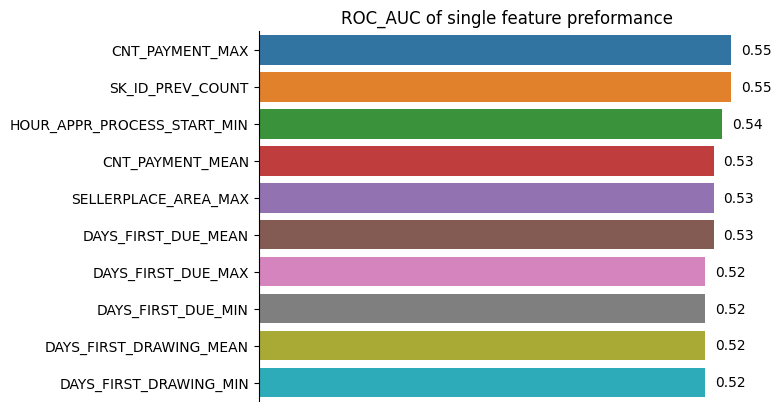

In [121]:
# Fitting selection pipe
selection_pipe.fit(X, y)

# Plotting the most important features
plot_important_features()

In previous applications the most important is the count of previous applications as well as the term of previous credit at the time of new application. The other features may be correlated with the others like when was the first drawing made. As we don't want to lose information we will save them as they are.

In [124]:
# Getting features to drop from the selection pipeline
features_to_drop = (selection_pipe.named_steps['drop_high_psi'].features_to_drop_ 
                    + selection_pipe.named_steps['sfp'].features_to_drop_ 
                    + ['TARGET'])

# Removing not important features and 'TARGET' from categorical set of features
merged_numerical.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_numerical.shape[1]} features of roc_auc single features performance greater than 0.52')

There are 12 features of roc_auc single features performance greater than 0.52


### Saving data with most important features from previous_application.csv

In [125]:
# Merging numerical and categorical data of importance
merged_previous_application = merged_numerical.merge(merged_categorical, on='SK_ID_CURR')

# Removing special characters from colum names
merged_previous_application.rename(columns=remove_special_chars, inplace=True)

# Saving data
reduce_memory_usage(merged_previous_application).to_csv('preprocessed_data/selected_previous_application.csv')

In [133]:
del previous

## Preprocessing of POS_CASH_balance.csv

* initial cleaning
* aggregations of numerical features
* aggregations of categorical features
* selecting most important features

### Getting data

In [8]:
# Getting data
pos_cash = load_data('POS_CASH_balance')

# Sorting credits 
pos_cash = pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

# Displaying head
pos_cash.head(2)

----------------------------------------------------------------------------------------------------
POS_CASH_balance.csv loading
memory usage reduced from 610.4MB to 276.6MB
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
8600392,2843499,314148,-30,10.00,0.00,Completed,0,0
5580339,2843499,314148,-31,10.00,0.00,Active,0,0


### Initial cleaning

In [9]:
# Changing sign of months_balance
pos_cash['MONTHS_BALANCE'] = pos_cash['MONTHS_BALANCE'].apply(lambda x: -x)

# Years away from application
pos_cash['YEARS_BALANCE'] = pos_cash['MONTHS_BALANCE'].apply(lambda x: x // 12)

### Aggregations of numerical features on SK_ID_CURR

In [30]:
# ============================== last 2 years ==============================

# Data from last 2 years
fresh_pos_cash = pos_cash.loc[pos_cash['YEARS_BALANCE'] <= 2]
fresh_pos_cash.drop('NAME_CONTRACT_STATUS', axis=1, inplace=True)

# Dictionary for aggregations
aggregations_fresh = {
    'MONTHS_BALANCE': ['min', 'mean'], 
    'CNT_INSTALMENT': ['mean', 'sum'],
    'CNT_INSTALMENT_FUTURE': ['mean'], 
    'SK_DPD': ['mean', 'sum', 'count'], 
    'SK_DPD_DEF': ['mean', 'sum', 'count']
}

# Aggreagating
fresh_pos_cash = fresh_pos_cash.groupby(['SK_ID_CURR']).agg(aggregations_fresh)
fresh_pos_cash.columns = [f"FRESH_{'_'.join(ele).upper()}" for ele in fresh_pos_cash.columns]

# ============================== over 2 years ==============================

# Data from over 2 years
old_pos_cash = pos_cash.loc[pos_cash['YEARS_BALANCE'] > 2]
old_pos_cash.drop('NAME_CONTRACT_STATUS', axis=1, inplace=True)

# Dictionary for older aggregations
aggregations_old = {
    'MONTHS_BALANCE': ['max', 'mean'], 
    'CNT_INSTALMENT': ['mean', 'sum'],
    'CNT_INSTALMENT_FUTURE': ['mean'], 
    'SK_DPD': ['mean', 'sum', 'count'], 
    'SK_DPD_DEF': ['mean', 'sum', 'count']
}

# Aggreagating
old_pos_cash = old_pos_cash.groupby(['SK_ID_CURR']).agg(aggregations_old)
old_pos_cash.columns = [f"OLD_{'_'.join(ele).upper()}" for ele in old_pos_cash.columns]


# Merging fresh and old features
pos_cash_merged = fresh_pos_cash.merge(old_pos_cash, right_index=True, left_index=True, how='outer')
pos_cash_merged.fillna(0, inplace=True)

### Aggregations of categorical feature on SK_ID_CURR

In [32]:
# Getting counts of each status for each previous credit 
agg_categorical = pd.crosstab(pos_cash['SK_ID_CURR'], pos_cash['NAME_CONTRACT_STATUS'])
agg_categorical.columns = [f"NAME_CONTRACT_STATUS_{ele.upper()}" for ele in agg_categorical.columns]

### Merging of aggregated columns

In [34]:
# Merging numerical, categorical and sk_id_curr
pos_cash_merged = pos_cash_merged.merge(agg_categorical, left_index=True, right_index=True)

# Merging with target variable
merged_pos_cash = id_and_target.merge(pos_cash_merged, left_on='SK_ID_CURR', right_index=True)

### Selecting important features 

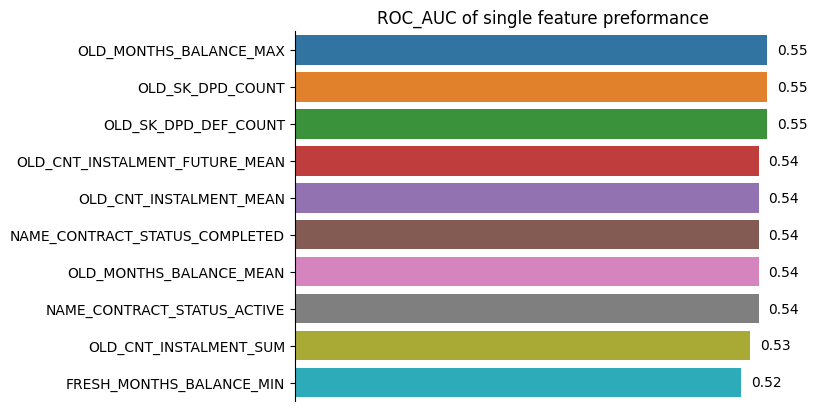

In [36]:
# Getting training data 
select_important = merged_pos_cash.loc[merged_pos_cash['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Fitting selection pipe
selection_pipe.fit(X, y)

# Plotting the most important features
plot_important_features()

From point of sales the data from over 2 years back is more important which is surprising. 

In [47]:
# Getting features to drop from the selection pipeline
features_to_drop = (selection_pipe.named_steps['drop_high_psi'].features_to_drop_ 
                    + selection_pipe.named_steps['sfp'].features_to_drop_
                    + ['TARGET'])

# Removing not important features and 'TARGET' from categorical set of features
merged_pos_cash.drop(features_to_drop, axis=1, inplace=True)
print(f'There are {merged_pos_cash.shape[1]-1} features of roc_auc single features performance greater than 0.52')

There are 12 features of roc_auc single features performance greater than 0.52


### Saving data with most most important features from POS_CASH_balance.csv

In [38]:
# Removing special characters from colum names
merged_pos_cash.rename(columns=remove_special_chars, inplace=True)

# Saving data
reduce_memory_usage(merged_pos_cash).to_csv('preprocessed_data/pos_cash_selected.csv')

# Deleting dataframe from memory
del pos_cash

## Preprocessing of installments_payments.csv

* getting the data
* feature engineering
* aggregating on fresh and old data on groups SK_ID_CURR
* selecting most important features
* saving outcome

### Getting the data

In [57]:
# Read in data
installments = load_data('installments_payments')

# Sorting values 
installments = installments.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], ascending=True)

# Displaying
installments.head(2)

----------------------------------------------------------------------------------------------------
installments_payments.csv loading
memory usage reduced from 830.4MB to 493.1MB
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.00,1,"-1,709.00","-1,715.00","3,951.00","3,951.00"
2568722,1369693,100001,1.00,2,"-1,679.00","-1,715.00","3,951.00","3,951.00"


### Feature engineering

In [58]:
# Adding features
installments['DIFF_DAYS_PAYMNET'] = installments['DAYS_INSTALMENT'] - installments['DAYS_ENTRY_PAYMENT']
installments['DIFF_AMT_INSTALLMENT'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']
installments['RATIO_AMT_PAYMENT'] = installments['AMT_INSTALMENT'] / (installments['AMT_INSTALMENT'] + 0.00001)
installments['YEARS_BALANCE'] = installments['DAYS_INSTALMENT'] // -365

### Aggreagating on SK_ID_CURR groups of fresh and old data

In [59]:
# Columns to aggregate
aggregations_columns = ['SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT', 'DIFF_DAYS_PAYMNET',
       'DIFF_AMT_INSTALLMENT', 'RATIO_AMT_PAYMENT']

# ============================== last 2 years ==============================

# Aggregating data from last 2 years
fresh_installments = installments.loc[installments['YEARS_BALANCE'] <= 2]
fresh_installments = fresh_installments[aggregations_columns].groupby(['SK_ID_CURR']).agg(['mean', 'max', 'sum', 'min'])
fresh_installments.columns = [f"FRESH_{'_'.join(ele).upper()}" for ele in fresh_installments.columns]

# ============================== over 2 years ==============================

# Aggregating data from over 2 years
old_installments = installments.loc[installments['YEARS_BALANCE'] > 2]
old_installments = old_installments[aggregations_columns].groupby(['SK_ID_CURR']).agg(['mean', 'max', 'sum', 'min'])
old_installments.columns = [f"OLD_{'_'.join(ele).upper()}" for ele in old_installments.columns]

# Merging fresh and old data aggregations
merged_installments_payments = fresh_installments.merge(old_installments, right_index=True, left_index=True, how='outer').fillna(0)

# Adding column with the count of SK_ID_CURR
count_sk_id_prev = installments.groupby(['SK_ID_CURR'])['SK_ID_PREV'].count().to_frame()
merged_installments_payments['PREVIOUS_CREDIT_COUNT'] = count_sk_id_prev['SK_ID_PREV']

### Merging with target variable

In [60]:
# Merging with target variable
merged_installments_payments = id_and_target.merge(merged_installments_payments, left_on='SK_ID_CURR', right_index=True)

,SK_ID_CURR,TARGET,FRESH_NUM_INSTALMENT_VERSION_MEAN,FRESH_NUM_INSTALMENT_VERSION_MAX,FRESH_NUM_INSTALMENT_VERSION_SUM,FRESH_NUM_INSTALMENT_VERSION_MIN,FRESH_NUM_INSTALMENT_NUMBER_MEAN,FRESH_NUM_INSTALMENT_NUMBER_MAX,FRESH_NUM_INSTALMENT_NUMBER_SUM,FRESH_NUM_INSTALMENT_NUMBER_MIN,FRESH_DAYS_INSTALMENT_MEAN,FRESH_DAYS_INSTALMENT_MAX,FRESH_DAYS_INSTALMENT_SUM,FRESH_DAYS_INSTALMENT_MIN,FRESH_DAYS_ENTRY_PAYMENT_MEAN,FRESH_DAYS_ENTRY_PAYMENT_MAX,FRESH_DAYS_ENTRY_PAYMENT_SUM,FRESH_DAYS_ENTRY_PAYMENT_MIN,FRESH_AMT_INSTALMENT_MEAN,FRESH_AMT_INSTALMENT_MAX,FRESH_AMT_INSTALMENT_SUM,FRESH_AMT_INSTALMENT_MIN,FRESH_AMT_PAYMENT_MEAN,FRESH_AMT_PAYMENT_MAX,FRESH_AMT_PAYMENT_SUM,FRESH_AMT_PAYMENT_MIN,FRESH_DIFF_DAYS_PAYMNET_MEAN,FRESH_DIFF_DAYS_PAYMNET_MAX,FRESH_DIFF_DAYS_PAYMNET_SUM,FRESH_DIFF_DAYS_PAYMNET_MIN,FRESH_DIFF_AMT_INSTALLMENT_MEAN,FRESH_DIFF_AMT_INSTALLMENT_MAX,FRESH_DIFF_AMT_INSTALLMENT_SUM,FRESH_DIFF_AMT_INSTALLMENT_MIN,FRESH_RATIO_AMT_PAYMENT_MEAN,FRESH_RATIO_AMT_PAYMENT_MAX,FRESH_RATIO_AMT_PAYMENT_SUM,FRESH_RATIO_AMT_PAYMENT_MIN,OLD_NUM_INSTALMENT_VERSION_MEAN,OLD_NUM_INSTALMENT_VERSION_MAX,OLD_NUM_INSTALMENT_VERSION_SUM,OLD_NUM_INSTALMENT_VERSION_MIN,OLD_NUM_INSTALMENT_NUMBER_MEAN,OLD_NUM_INSTALMENT_NUMBER_MAX,OLD_NUM_INSTALMENT_NUMBER_SUM,OLD_NUM_INSTALMENT_NUMBER_MIN,OLD_DAYS_INSTALMENT_MEAN,OLD_DAYS_INSTALMENT_MAX,OLD_DAYS_INSTALMENT_SUM,OLD_DAYS_INSTALMENT_MIN,OLD_DAYS_ENTRY_PAYMENT_MEAN,OLD_DAYS_ENTRY_PAYMENT_MAX,OLD_DAYS_ENTRY_PAYMENT_SUM,OLD_DAYS_ENTRY_PAYMENT_MIN,OLD_AMT_INSTALMENT_MEAN,OLD_AMT_INSTALMENT_MAX,OLD_AMT_INSTALMENT_SUM,OLD_AMT_INSTALMENT_MIN,OLD_AMT_PAYMENT_MEAN,OLD_AMT_PAYMENT_MAX,OLD_AMT_PAYMENT_SUM,OLD_AMT_PAYMENT_MIN,OLD_DIFF_DAYS_PAYMNET_MEAN,OLD_DIFF_DAYS_PAYMNET_MAX,OLD_DIFF_DAYS_PAYMNET_SUM,OLD_DIFF_DAYS_PAYMNET_MIN,OLD_DIFF_AMT_INSTALLMENT_MEAN,OLD_DIFF_AMT_INSTALLMENT_MAX,OLD_DIFF_AMT_INSTALLMENT_SUM,OLD_DIFF_AMT_INSTALLMENT_MIN,OLD_RATIO_AMT_PAYMENT_MEAN,OLD_RATIO_AMT_PAYMENT_MAX,OLD_RATIO_AMT_PAYMENT_SUM,OLD_RATIO_AMT_PAYMENT_MIN,PREVIOUS_CREDIT_COUNT
0,100002,1,1.05,2.00,20.00,1.00,10.00,19.00,190.00,1.00,-295.00,-25.00,"-5,605.00",-565.00,-315.42,-49.00,"-5,993.00",-587.00,"11,559.25","53,093.75","219,625.70","9,251.77","11,559.25","53,093.75","219,625.70","9,251.77",20.42,31.00,388.00,12.00,0.00,0.00,0.00,0.00,1.00,1.00,19.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19
1,100003,0,1.08,2.00,14.00,1.00,3.77,7.00,49.00,1.00,-670.31,-536.00,"-8,714.00",-797.00,-677.85,-544.00,"-8,812.00",-806.00,"118,314.71","560,835.36","1,538,091.27","64,275.61","118,314.71","560,835.36","1,538,091.27","64,275.61",7.54,14.00,98.00,3.00,0.00,0.00,0.00,0.00,1.00,1.00,13.00,1.00,1.00,1.00,12.00,1.00,6.50,12.00,78.00,1.00,"-2,145.00","-1,980.00","-25,740.00","-2,310.00","-2,151.75","-1,985.00","-25,821.00","-2,324.00","6,731.12","6,737.31","80,773.38","6,662.97","6,731.12","6,737.31","80,773.38","6,662.97",6.75,14.00,81.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,12.00,1.00,25


### Selecting important features

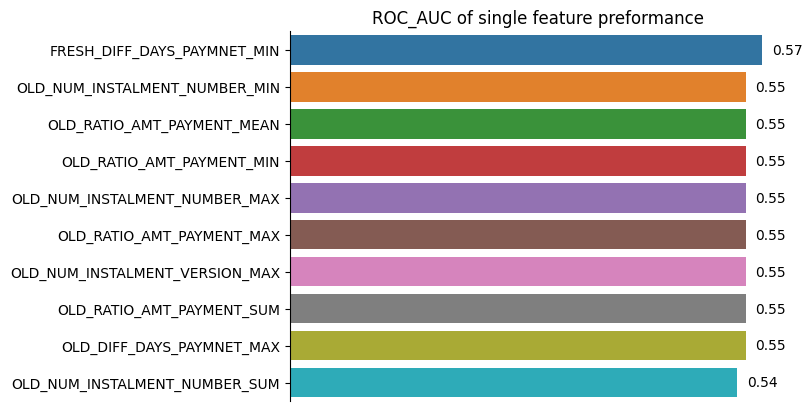

In [61]:
# Getting training data 
select_important = merged_installments_payments.loc[merged_installments_payments['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Fitting selection pipe
selection_pipe.fit(X, y)

# Plotting the most important features
plot_important_features()

In [62]:
# Getting features to drop from the selection pipeline
features_to_drop = (selection_pipe.named_steps['drop_high_psi'].features_to_drop_ 
                    + selection_pipe.named_steps['sfp'].features_to_drop_ 
                    + ['TARGET'])

# Removing not important features and 'TARGET' from categorical set of features
merged_installments_payments.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_installments_payments.shape[1] - 1} features of roc_auc single features performance greater than 0.52')

There are 38 features of roc_auc single features performance greater than 0.52


### Saving data with the most important features from installments_payments.csv

In [63]:
reduce_memory_usage(merged_installments_payments).to_csv('preprocessed_data/installments_payments_selected.csv')

In [67]:
# del installments_payments

NameError: name 'installments_payments' is not defined

## Preprocessing of credit_card_balance.csv

* initial preprocessing from eda
* creating new features
* aggreagating on fresher and older data
* merging results with SK_ID_CURR
* aggregating on groups SK_ID_CURR
* selecting features

### Getting data

In [64]:
# Reading in the data
ccb = reduce_memory_usage(pd.read_csv('credit_card_balance.csv'))

# Sorting dataframe by previous applications and months_balance
ccb = ccb.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

# Displaying 
ccb.head(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1726835,2843496,425374,-1,0.00,630000,0.00,0.00,0.00,0.00,0.00,121.77,121.77,0.00,0.00,0.00,0.00,0,0.00,0.00,11.00,Active,0,0
287677,2843496,425374,-2,0.00,630000,0.00,0.00,0.00,0.00,328.23,121.77,121.77,0.00,0.00,0.00,0.00,0,0.00,0.00,11.00,Active,0,0


### Initial cleaning and feature engineering

In [68]:
# Removing too high values in AMT_PAYMENT_CURRENT
ccb['AMT_PAYMENT_CURRENT'].loc[ccb['AMT_PAYMENT_CURRENT'] > 4*10**6] == np.nan

# Creating new features
ccb['BALANCE_LIMIT_RATIO'] = ccb['AMT_BALANCE'] / (ccb['AMT_CREDIT_LIMIT_ACTUAL'] + 0.0001)
ccb['AMT_DRAWING_ALL'] = ccb['AMT_DRAWINGS_ATM_CURRENT'] + ccb['AMT_DRAWINGS_CURRENT'] + ccb[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + ccb['AMT_DRAWINGS_POS_CURRENT']
ccb['YEARS_BALANCE'] = ccb['MONTHS_BALANCE'] // -12

# Changing sign on months_balance
ccb['MONTHS_BALANCE'] = ccb['MONTHS_BALANCE'].apply(lambda x: -x)

### Aggregating on new and old data on SK_ID_CURR

In [69]:
# Columns of importance from EDA
aggregations_columns = [
    'SK_ID_CURR',
    'MONTHS_BALANCE', 'AMT_BALANCE',
    'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
    'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
    'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
    'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
    'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
    'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
    'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
    'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD',
    'SK_DPD_DEF', 'BALANCE_LIMIT_RATIO', 'AMT_DRAWING_ALL',
]

# ============================== last 2 years ==============================

# Aggregating on data from last 2 years
fresh_ccb = ccb.loc[ccb['YEARS_BALANCE'] <= 2]
fresh_ccb = fresh_ccb[aggregations_columns].groupby(['SK_ID_CURR']).agg(['min', 'mean', 'max', 'sum'])
fresh_ccb.columns = [f"FRESH_{'_'.join(ele).upper()}" for ele in fresh_ccb.columns]

# ============================== over 2 years ==============================

# Aggregating on data from over 2 years
old_ccb = ccb.loc[ccb['YEARS_BALANCE'] > 2]
old_ccb = old_ccb[aggregations_columns].groupby(['SK_ID_CURR']).agg(['min', 'mean', 'max', 'sum'])
old_ccb.columns = [f"OLD_{'_'.join(ele).upper()}" for ele in old_ccb.columns]

# Merging both and filling in missing values with 0
merged_ccb = fresh_ccb.merge(old_ccb, right_index=True, left_index=True, how='outer').fillna(0)

# Adding column with the count of SK_ID_CURR
count_sk_id_prev = ccb.groupby(['SK_ID_CURR'])['SK_ID_PREV'].count().to_frame()
merged_ccb['PREVIOUS_CREDIT_CARD_COUNT'] = count_sk_id_prev['SK_ID_PREV']

### Merging with target variable 

In [70]:
# Merging with target variable
merged_ccb = id_and_target.merge(merged_ccb, left_on='SK_ID_CURR', right_index=True)

### Selecting important features

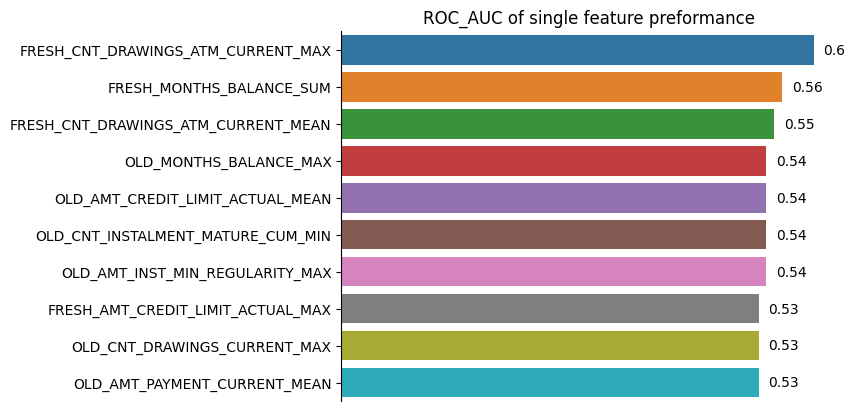

In [72]:
from feature_engine.selection import SmartCorrelatedSelection
# Getting training data 
select_important = merged_ccb.loc[merged_ccb['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Creating pipeline for selection
selection_pipe = Pipeline(steps=[
    ('drop_high_psi', DropHighPSIFeatures()),
    ('scs', SmartCorrelatedSelection()),
    ('sfp', SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    threshold=0.52,
                    cv=3))
   
     ])

# Fitting selection pipe
selection_pipe.fit(X, y)

# Plotting the most important features
plot_important_features()

In [36]:
# Getting features to drop from the selection pipeline
features_to_drop = (selection_pipe.named_steps['drop_high_psi'].features_to_drop_ 
                    + selection_pipe.named_steps['sfp'].features_to_drop_ 
                    + selection_pipe.named_steps['scs'].features_to_drop_
                    + ['TARGET'])

# Removing not important features and 'TARGET' from categorical set of features
merged_ccb.drop(features_to_drop, axis=1, inplace=True)
print(f'There are {merged_ccb.shape[1] - 1} features of roc_auc single features performance greater than 0.52')

There are 3 features of roc_auc single features performance greater than 0.52


### Saving data with most important features from POS_CASH_balance.csv

In [19]:
merged_ccb.to_csv('preprocessed_data/credit_card_balance_selected.csv')

In [20]:
del ccb
del merged_ccb

## Preprocessing of application_train.csv

* getting data
* initial cleaning based on EDA
* splitting for train, validation and test set
* imputation
* feature engineering
* selecting columns of interest
* saving dataframe

### Getting data 

In [92]:
# Columns of interes from EDA
col_interest = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
                 'REGION_RATING_CLIENT_W_CITY', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DEF_30_CNT_SOCIAL_CIRCLE',
                 'DEF_60_CNT_SOCIAL_CIRCLE', 'OWN_CAR_AGE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',
                 'EXT_SOURCE_1', 'HOUR_APPR_PROCESS_START', 'CNT_CHILDREN', 'ELEVATORS_MODE',
                 'CNT_FAM_MEMBERS', 'FLOORSMIN_MODE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'ELEVATORS_MEDI',
                 'FLOORSMIN_MEDI', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'ENTRANCES_MEDI', 'FLOORSMAX_AVG',
                 'ENTRANCES_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
                 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BUILD_MODE', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 
                 'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_REQ_CREDIT_BUREAU_MON', 'YEARS_BUILD_AVG',
                 'FLOORSMIN_AVG', 'OBS_60_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE',
                'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT', 'NAME_EDUCATION_TYPE',
                'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE',
                'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_6',
                'FLAG_PHONE', 'WALLSMATERIAL_MODE', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
                'HOUSETYPE_MODE', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_18', 'NAME_TYPE_SUITE', 'REG_REGION_NOT_WORK_REGION',
                'FONDKAPREMONT_MODE', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_15', 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_21', 
                'DAYS_EMPLOYED', 'TARGET']

# Loading data
application = load_data('application_train')

# Display
application.head(2)

----------------------------------------------------------------------------------------------------
application_train.csv loading
memory usage reduced from 286.2MB to 129.3MB
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


### Initial cleaning of data based on EDA

* checking if any columns have drift in distribution - if so remove them
* assign ordinality to NAME_EDUCATION_TYPE
* reduce the number of features with high cardinality
* replace not known values in gender and encode
* encode FLAG_OWN_CAR, FLAG_OWN_REALTY
* replace columns with negative values
* removing nonsense values

In [93]:
# Assign ordinality to NAME_EDUCATION_TYPE
education = {'Secondary / secondary special': 1,
             'Higher education': 3,
             'Incomplete higher': 2,
             'Lower secondary': 0,
             'Academic degree': 4}
application['NAME_EDUCATION_TYPE'] = application['NAME_EDUCATION_TYPE'].map(education)

# Reducing the number of cardinality in ORGANIZATION-TYPE 
application['ORGANIZATION_TYPE'] = application['ORGANIZATION_TYPE'].map(organization_replacer)

# Replacing CODE_GENDER
application['CODE_GENDER'].replace({'XNA': np.nan, 'M': 0, 'F': 1}, inplace=True)

# Change days employed 365.243 to 243
application['DAYS_EMPLOYED'] = application['DAYS_EMPLOYED'].replace({365243: np.nan})

# Changing sign of negative columns
for col in ['DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED']:
    application[col] = application[col].map(change_sign)

# Encode 
#df_1['FLAG_OWN_CAR'] = df_1['FLAG_OWN_CAR'].map(y_n_encode)
#df_1['FLAG_OWN_REALTY'] = df_1['FLAG_OWN_REALTY'].map(y_n_encode)

# Application process
ewd = EqualWidthDiscretiser(bins=6)
ewd.fit(application.HOUR_APPR_PROCESS_START.to_frame())
application['HOUR_APPR_PROCESS_START'] = ewd.transform(application.HOUR_APPR_PROCESS_START.to_frame())

### Splitting data 

In [94]:
X_train = application.loc[application['SK_ID_CURR'].isin(application_id_train)].drop('TARGET', axis=1)
y_train = application.loc[application['SK_ID_CURR'].isin(application_id_train)]['TARGET']
X_val = application.loc[application['SK_ID_CURR'].isin(application_id_val)].drop('TARGET', axis=1)
y_val = application.loc[application['SK_ID_CURR'].isin(application_id_val)]['TARGET']
X_test = application.loc[application['SK_ID_CURR'].isin(application_id_test)].drop('TARGET', axis=1)
y_test = application.loc[application['SK_ID_CURR'].isin(application_id_test)]['TARGET']

### Preprocessing

In [24]:
# Getting categorical data 
categorical = [var for var in X_train.columns if X_train[var].dtype == 'O']

# Removing rare columns
rle = RareLabelEncoder(tol=0.04, n_categories=1, variables=categorical, missing_values='ignore')
rle.fit(X_train)
X_train = rle.transform(X_train)
X_val = rle.transform(X_val)
X_test = rle.transform(X_test)

In [95]:
label = 'TARGET'

# make a list of categorical variables
categorical = [var for var in X_train.columns if X_train[var].dtype == 'O']

# make a list of numerical variables
numerical = [var for var in X_train.columns if X_train[var].dtype != 'O']

# make a list of discrete variables
discrete = [ var for var in numerical if len(X_train[var].unique()) < 20]

# categorical encoders work only with object type variables
# to treat numerical variables as categorical, we need to re-cast them
#X_train[discrete]= X_train[discrete].astype('category')

# continuous variables
numerical = [
    var for var in numerical if var not in discrete
    ]


In [28]:
scale_pos_weight = (y_train == 0 ).sum() / (y_train ==1).sum()
round(scale_pos_weight, 2)

12.72

### Preprocessing and feature engineering pipeline

The features will be engineered based on the domain knowladge, eda and the features that turned out to be correlated with the target and research on the topic.

In [ ]:
preprocess_pipe = Pipeline(steps=[
    # replace NA by the median in the 2 variables below, they are numerical
    ('continuous_var_median_imputer', MeanMedianImputer(
        imputation_method='median', variables=numerical
    )),
    # replace NA in discrete variables by mode value
    ('discreate_var_mode_imputer',CategoricalImputer(imputation_method='frequent',
                                                     ignore_format=True,
                                                    variables=discrete)),

    # replace NA by adding the label "Missing" in categorical variables
    ('categorical_imputer', CategoricalImputer(fill_value='XNA', variables=categorical)),
    
    # encode categorical variables using the target mean
    ('one_hot_encoder', OneHotEncoder(variables=categorical)),
    # ('woeencoder', WoEEncoder(variables=[cat for cat in categorical if cat not in ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 
    #                                              'EMERGENCYSTATE_MODE']], unseen='ignore', fill_value=0.0001))
    ('nearest_neighbours',  FunctionTransformer(mean_knn)), 
    ('pandarizer', FunctionTransformer(lambda x: pd.DataFrame(x, 
                        columns=preprocess_pipe.named_steps['one_hot_encoder'].get_feature_names_out()+['MEAN_100_KNN', 'MEAN_50_KNN']))),
    ('f_1', MathFeatures(['DAYS_EMPLOYED', 'DAYS_BIRTH'], devision, ['RATIO_EMPLOYED_TO_AGE'])),
    ('f_2', MathFeatures(['AMT_ANNUITY', 'AMT_INCOME_TOTAL'], devision, ['RATIO_ANNUITY_TO_INCOME'])),
    ('f_3', MathFeatures(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'AMT_INCOME_TOTAL'], sum_dev, ['REGION_TO_INCOME'])),
    ('f_4', MathFeatures(['AMT_INCOME_TOTAL', 'EXT_SOURCE_3'], devision, ['RATIO_INCOME_TO_EXT_SOURCE'])),
    ('f_5', MathFeatures(['AMT_CREDIT', 'EXT_SOURCE_3'], devision, ['RATIO_CREDIT_TO_EXT_SOURCE'])),
    ('f_6', MathFeatures(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], 
                         [np.sum, np.mean, np.max, np.min, np.prod, weighted_mul],
                        ['SUM_EXT_SOURCES', 'MEAN_EXT_SOURCES', 'MAX_EXTERNAL_SOURCES', 'MIN_EXT_SOURCES', 'PROD_EXT_SOURCES', 'WEIGHTED_EXT_SOURCES'])),
    ('f_7', MathFeatures(['AMT_CREDIT', 'AMT_ANNUITY'], devision, ['CREDIT_ANNUITY_RATIO'])),
    ('f_8', MathFeatures(['REGION_POPULATION_RELATIVE', 'AMT_CREDIT'], np.prod, ['PROD_REGION_POPULATION_AMT_CREDIT'])),
    ('f_9', MathFeatures(['REGION_RATING_CLIENT', 'AMT_INCOME_TOTAL'], np.prod, ['PROD_REGION_RATING_AMT_INCOME'])),
    ('f_10', MathFeatures(['AMT_INCOME_TOTAL', 'CNT_CHILDREN'], devision, ['INCOME_PER_CHILD'])),
    ('f_11', MathFeatures(['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS'], devision, ['INCOME_PER_PERSON'])),
    ('f_12', MathFeatures(['AMT_ANNUITY', 'AMT_INCOME_TOTAL'], devision, ['ANNUITY_INCOME_PERC'])),
    ('f_13', MathFeatures(['AMT_ANNUITY', 'AMT_CREDIT'], devision, ['PAYMENT_RATE'])),
    ('col_names', FunctionTransformer(lambda x: x.rename(columns=remove_special_chars)))

])

preprocess_pipe.fit(X_train, y_train)
X_train_prep = preprocess_pipe.transform(X_train)
X_val_prep = preprocess_pipe.transform(X_val)
X_test_prep = preprocess_pipe.transform(X_test)

#### Features selection 

In [ ]:
# Features selection based on the model
# initialize feature selector
rfe = RecursiveFeatureElimination(estimator=RandomForestClassifier(max_depth=10), scoring="roc_auc", cv=3)
rfe.fit(X_train_prep.reset_index(drop=True), y_train.reset_index(drop=True))

In [ ]:
X_train_selected = rfe.transform(X_train_prep)
X_val_selected = rfe.transform(X_val_prep)
X_train_val_selected = rfe.transform(X_train_val_prep)
X_test_selected = rfe.transform(X_test_prep)

In [200]:
def plot_features_importance(model_name: str, selection=rfe) -> None:
    """Plots 30 most important features based on the selection pipeline.
    Parameters: Pipeline for selecting features, model_name (name of model used for Recursive Feature Elimination)
    Returns: None"""
    important_features = pd.Series(rfe.performance_drifts_).sort_values(ascending=False)[:30].reset_index()
    important_features.columns = ['feature', 'importance']
    plt.figure(figsize=(8, 10))
    sns.barplot(data=important_features, x='importance', y='feature')
    plt.title(f"Importance of Features Selected with {model_name} RecursiveFeatureElimination")
    plt.xlabel("")
    plt.ylabel("")
    plt.yticks(size=7)

In [ ]:
print('-'*100)
print(f'Number of selected features: {X_selected_train.shape[1]}')
print(f'Initial roc_auc: {round(rfe.initial_model_performance_, 2)}')
print('-'*100)
plot_features_importance('Random Forest')